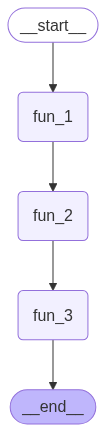

[fun_1]:START: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={})], 'validation_passed': False}
[fun_1]:END: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}), HumanMessage(content='fun_1', additional_kwargs={}, response_metadata={})], 'validation_passed': False}
[fun_2]:START: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}), HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}), HumanMessage(content='fun_1', additional_kwargs={}, response_metadata={})], 'validation_passed': False}
[fun_2]:END: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}), HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}), HumanMessage(content='fun_1', additional_kwargs={}, response_metadata={})], 'validation_passed': False}
[fun_3]:START: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}), HumanMessage(c

In [21]:
import warnings
warnings.filterwarnings('ignore')

import os
from dotenv import load_dotenv
load_dotenv()

import re
from typing import Dict
import pprint
from langchain import hub
from langchain.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain.prompts import PromptTemplate
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain_community.tools import DuckDuckGoSearchRun
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langchain_core.messages import SystemMessage, AIMessage

import pinecone  # Official Pinecone SDK to create/manage index
from pinecone import ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from langgraph.graph import START, END, StateGraph
import operator
from typing_extensions import TypedDict, Annotated
from typing import Sequence
from langchain_core.messages import BaseMessage

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
PINECONE_API_KEY=os.getenv('PINECONE_API_KEY')
PINECONE_INDEX_ENVIRONMENT=os.getenv('PINECONE_INDEX_ENVIRONMENT')
PINECONE_CLOUD = os.getenv('PINECONE_CLOUD')
PINECONE_INDEX_NAME = os.getenv('PINECONE_INDEX_NAME')


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    validation_passed: bool = False

def fun_1(state: AgentState):
    print(f"[fun_1]:START: {state}")
    fun_op = 'fun_1'
    final_op = {
        "messages": state["messages"] + [HumanMessage(content=fun_op)],
        "validation_passed": state.get("validation_passed", False)
    }
    print(f"[fun_1]:END: {final_op}")
    return final_op


def fun_2(state: AgentState):
    print(f"[fun_2]:START: {state}")
    fun_op = 'fun_2'
    final_op = {
        "messages": state["messages"] + [HumanMessage(content=fun_op)],
        "validation_passed": state.get("validation_passed", False)
    }
    print(f"[fun_2]:END: {state}")

    return final_op

def fun_3(state: AgentState):
    print(f"[fun_3]:START: {state}")
    fun_op = 'fun_3'
    final_op = {
            "messages": state["messages"] + [HumanMessage(content=fun_op)],
            "validation_passed": True
        }    
    print(f"[fun_3]:END: {state}")

    return final_op

wf = StateGraph(AgentState)

wf.add_node('fun_1', fun_1)
wf.add_node('fun_2', fun_2)
wf.add_node('fun_3', fun_3)

wf.add_edge(START, 'fun_1')
wf.add_edge('fun_1', 'fun_2')
wf.add_edge('fun_2', 'fun_3')
wf.add_edge('fun_3', END)

app = wf.compile()

display(Image(app.get_graph().draw_mermaid_png()))

from langchain_core.messages import HumanMessage

response = app.invoke({
    "messages": [HumanMessage(content="Hi")],
    "validation_passed": False
})


In [23]:
response['messages'][-1].content

'fun_3'

In [25]:
response['validation_passed']

True

In [ ]:
# supervisor function
def supervisor(state: AgentState):
    print(f"[supervisor]: START: {state}")

    question = state['messages'][0]

    template = """
                You are a classification agent. Classify the following user question into one of the following categories ONLY:
                [r​ag, llm, web]

                **Definitions:**
                - rag: The question can be better answered using retrieval from external knowledge or documents.
                - llm: The question can be answered by the language model's own reasoning or general knowledge.
                - web: The question requires fresh or current information from the internet.

                You MUST answer with exactly one word: either rag, llm, or web.

                User question: {question},
                {format_instructions}
                """

    prompt = PromptTemplate(
        template=template,
        input_variables=['question'],
        partial_variables={'format_instructions': parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    response = chain.invoke({'question': question})
    
    final_op = {
        "messages": state["messages"] + [SystemMessage(content=response.Topic)],
        "validation_passed": state.get("validation_passed", False)
    }

    print(f"messages: {response.Topic}")
    print(f"[supervisor]: END: {final_op}")
    print(f'EXIT from supervisor')

    return final_op


In [ ]:
def validation_router(state: AgentState)-> AgentState:
    """Validates LLM response based on different use case rules."""
    print(f"[validation_router]: START: {state}")

    # messages = state["messages"]
    # response = messages[-1].content if isinstance(messages[-1], AIMessage) else ""

    # # Utility flags
    # is_multiline = len(response.strip().splitlines()) >= 2
    # no_hallucination = not re.search(r"\b(I am an AI|I'm just an AI|I'm a language model)\b", response, re.I)
    # no_generic_response = not any(
    #     phrase in response.lower()
    #     for phrase in [
    #         "i'm sorry", "as an ai", "i don't know", "i cannot", "i'm not sure", "this depends"
    #     ]
    # )
    # not_incomplete = not response.strip().endswith("...")
    
    # # -----------------------
    # # 🧠 1. Factual Q&A (RAG)
    # # Must cite at least 1 chunk (assume via [1], (source:...), etc.)
    # has_reference = bool(re.search(r"\[\d+\]|\(source:.*?\)", response, re.I))

    # # -----------------------
    # # 🧠 2. Structured Output (JSON or Pydantic-style)
    # is_structured = response.strip().startswith("{") and response.strip().endswith("}")
    # # OR check if it was expected to return structured and fails to do so (up to use case)

    # # -----------------------
    # # 🧠 3. Customer Support Bot
    # has_empathy = any(word in response.lower() for word in ["understand", "sorry", "i can help", "let me assist"])
    # has_solution = any(word in response.lower() for word in ["please try", "you can", "we suggest", "solution", "steps", "recommend"])

    # -----------------------
    # Global validation logic — you can OR/AND depending on routing
    # is_valid = all([
    #     is_multiline,
    #     no_hallucination,
    #     no_generic_response,
    #     not_incomplete,
    #     has_reference or is_structured or (has_empathy and has_solution)
    # ])

    # is_valid = all([no_hallucination, not_incomplete])

    # Debug logs
    # print("----Validation Breakdown----")
    # print("Multiline:", is_multiline)
    # print("No Hallucination:", no_hallucination)
    # print("No Generic Response:", no_generic_response)
    # print("Not Incomplete:", not_incomplete)
    # print("Has Reference:", has_reference)
    # print("Is Structured:", is_structured)
    # print("Has Empathy:", has_empathy)
    # print("Has Solution:", has_solution)
    
    # return {
    #     **state,
    #     "validation_passed": is_valid
    # }
    is_valid = True

    print(f"[validation_router]: END: {state}")
    print(f"validation_passed: {is_valid}")
    print("EXIT from validation_router")
    
    fun_op = {'validation_passed': state.messages + SystemMessage(content=str(is_valid))}
    print(f"[validate]: END: validation_passed = {is_valid}")

    return fun_op



In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node('supervisor', supervisor)
workflow.add_node('rag', rag)
workflow.add_node('llm', llm)
workflow.add_node('web', web)
workflow.add_node('validation_router', validation_router)

workflow.add_conditional_edges('supervisor', router, {
    'rag': 'rag',
    'web': 'web',
    'llm': 'llm'
})

workflow.add_edge('rag', 'validation_router')
workflow.add_edge('llm', 'validation_router')
workflow.add_edge('web', 'validation_router')

# ⬇ Updated conditional re-routing logic
workflow.add_conditional_edges("validation_router", route_validation, {
    "__end__": "__end__",
    "llm": "llm",
    "rag": "rag",
    "web": "web"
})

workflow.set_entry_point('supervisor')
workflow.add_edge("validation_router", END)

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))
